## Express Checkout 

### Overview
I want to create and analyise a checkout (queue) model for a hypotethical general store in a small, but growing, regional area. 

This hypothetical store currently has one queue and one checkout counter but, with a growing population, management is considering new checkout options. I want to comapre *one queue, one checkout station* to the following checkout models : 

- One queue, Two checkout stations - where the 2nd is only opened if 3 or more customers are waiting in line.  
- Two queues, Two checkout stations - where one is an *express*  station for customers with 10 or less items.  In this model, if no customers are in the *express* queue, the express checkout server will take the next customer in the non-express queue.

Let's provide some analysis and recommendations on which checkout configuration would provide the *quickest* checkout service for their customers. 

### One queue or two? 

Assume that a customer is equally likely to arrive during any timestep.  We'll denote this probability using the Greek letter lambda, $\lambda$, or the variable name `lam`.  

Based on data provided, we know that it takes 5 minutes, on average, for a customer to check out.  Though checkout times are highly variable.  A simple way to model this variability is to assume that when a customer is checking out, they have the same probability of finishing up during each time step.  We'll denote this probability using the Greek letter mu, $\mu$, or the variable name `mu`.  

*The number of items in their cart will affect their checkout time, so we'll consider how checkout time is affected by the number of items.*

In [12]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# set the random number generator
np.random.seed(0)

### 1 - One Queue, One Station
We'll start by simulating the current checkout setup: one queue with one checkout station.  

### 1.a - One Queue, One Station - Functions 

In [13]:
def make_system(kwargs):    
    
    """Make a System object.
    
    kwargs: dictionary of key word arguments, which define system
    
    returns: System object
    """

    return System(kwargs)


def update_func_1q1s(x, t, system):
    
    """Simulate one time step.
    
    x: number of people in the shop
    t: time step
    system: System object
    
    returns: x, current value
    """
    # if there's a customer in service, check if they're done
    if x > 0:
        if flip(system.mu):
            x -= 1
            
    # check for an arrival
    if flip(system.lam):
        x += 1
        
    return x

def run_simulation(system, update_func):
    
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    
    returns: simulation results in TimeSeries object
    """
    x = 0
    results = TimeSeries()
    results[0] = x
    
    for t in linrange(0, system.duration):
        x = update_func(x, t, system)
        results[t+1] = x

    return results

def param_sweep(low_range, high_range, param, num_vals):  
    
    """ Generate an array of values for a 
        parameter by sweeping through a range of possible values, 
        from low to high
    
    low_range: low range of possible values
    high_range: high range of possible values
    param: parameter to sweep 
    num_vals: number of values between low to high to generate
    
    returns: array of parameter values
    """
    param_array = linspace(low_range*param, high_range*param, num_vals)
    return param_array

def compute_metrics(results, system):
        
    """Compute average number of customers and wait time.
    
    results: TimeSeries of queue lengths
    system: System object
    
    returns: L, W
    """
    L = results.mean()
    W = L / system.lam
    return L, W

def sweep_lam(lam_array, system, update_func):
   
    """ Runs simulations using a range of values for `lam`
    
    lam_array: array of values for `lam`
    system: current system object
    update_func: passed along to run_simulation
    make_system_func: passed along to create system
    
    returns: SweepSeries of average wait time vs lam
    """
    sweep = SweepSeries()
    
    for lam in lam_array:
        sweep_system = make_system({'lam':lam, 
                                    'mu':system.mu, 
                                    'duration': system.duration})
        results = run_simulation(sweep_system, update_func)
        L, W = compute_metrics(results, sweep_system)
        sweep[lam] = W
        
    return sweep


###  1.b -  One Queue, One Station -  Generate data & Plot scenario  
Lets generate and plot data for the *One queue, One station* checkout scenario using both the theorectial and simulated results.  The plot title provides the calculated **W_avg** for the One queue, One station scenario to two decimal places 


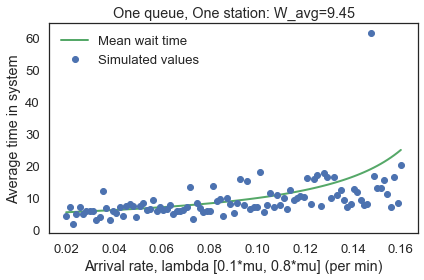

In [14]:
""" Generate Data: One queue, One station scenario
"""

# Define key word arguments for One queue, One station checkout system
kwargs_1q1s = {'lam':1/8, 'mu':1/5, 'duration': 10*60}

system = make_system(kwargs_1q1s)
                      
lam_array = param_sweep(0.1, 0.8, system.mu, 101)
sweep = sweep_lam(lam_array, system, update_func_1q1s);

""" Plot theoretical and simulated data: One queue, One stations scenario
"""
# Calculate theoretical mean wait times
W = 1 / (system.mu - lam_array)
plot(lam_array, W, 'g-', label="Mean wait time")
W_avg = sweep.mean()
W_avg = round(W_avg, 2)

# Plot simulated scenario
plot(sweep, 'bo', label="Simulated values")
decorate(xlabel='Arrival rate, lambda [0.1*mu, 0.8*mu] (per min)',
         ylabel='Average time in system',
         title='One queue, One station: W_avg='+str(W_avg))  

### 2 - One Queue, Two Stations 
Now we'll explore our 2nd scenario: one queue with two checkout stations. But the 2nd station is only opened if 3 or more customers are waiting in in the queue.

### 2.a - One Queue, Two Stations - Functions 

In [15]:
def update_func_1q2s(x, t, system):
        
    """Simulate a single queue with two checkout stations.
    
    x: number of customers in queue
    t: not used
    system: System object
    
    returns: x number of customers in queue
    """
    # check whether the first is complete
    if x > 0 and flip(system.mu):
        x -= 1

    # if there are 3 or more in the queue, check if the
    # second checkout station is complete
    if x >= 3 and flip(system.mu):
        x -= 1            
    
    # check for an arrival
    if flip(system.lam):
        x += 1
        
    return x

### 2.b - One Queue, Two Stations - Generate data & Plot scenario 
Let's generate and plot data for the *One queue, Two stations* checkout scenario using both the theorectial and simulated results.


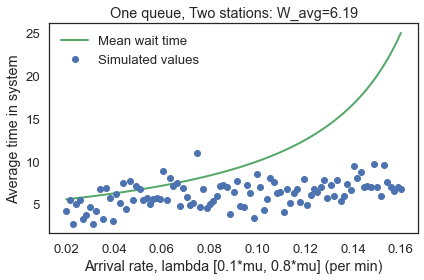

In [16]:
""" Generate Data: One queue, Two stations scenario
"""
kwargs = {'lam':1/8, 'mu':1/5, 'duration': 10*60}
system = make_system(kwargs)
                      
lam_array = param_sweep(0.1, 0.8, system.mu, 101)
sweep = sweep_lam(lam_array, system, update_func_1q2s);


""" Plot theoretical and simulated data: One queue, Two stations scenario
"""
# Calculate theoretical mean wait times
W = 1 / (system.mu - lam_array)
plot(lam_array, W, 'g-', label="Mean wait time")

W_avg = sweep.mean()
W_avg = round(W_avg, 2)

# Plot simulated scenario
plot(sweep, 'bo', label="Simulated values")
decorate(xlabel='Arrival rate, lambda [0.1*mu, 0.8*mu] (per min)',
         ylabel='Average time in system',
         title='One queue, Two stations: W_avg='+str(W_avg))  

### 3 - Express checkout:  
Now we'll explore our 3rd scenario: two queues with two checkout stations. Where the 2nd station is an express station for customers with 10 or less items. But the express queue does also provide a backup.  If no customers are in the express queue, the express checkout server will take the next customer from the full service queue.

### 3.a - Express Checkout - Functions


In [17]:

def update_func_express(x_full, x_express, t, system):
    """Simulate two queues with one server each.
    
    x_full: number of customers in full service queue
    x_express: number of customers in express queue
    t: time step
    system: System object
    
    returns: current x_full, x_express values
    """
    # if the full service checkout is busy, check if it's done
    if x_full > 0 and flip(system.mu):
        x_full -= 1
            
    # if the express queue is busy, check if it's done
    if x_express > 0 and flip(system.mu):
        x_express -= 1
            
    # check for an arrival
    if flip(system.lam):
        # join appropriate queue per number of items
        if flip(system.express):
            x_express += 1
        # If no customers are in the express queue, the 
        # express checkout server will take the next customer 
        # in the non-express queue
        #   elif x_express == 0:
        # OR 
        # if x_full has customers and x_press doesn't, take the next customer
        elif x_full > 0 and x_express == 0:
            x_express += 1
        else:
            x_full += 1
            
    return x_full, x_express

def run_simulation_express(system, update_func):  
    
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    
    returns: TimeSeries array of simulated results
    """
    x_full, x_express = 0, 0
    results = TimeSeries()
    results[0] = x_full + x_express
    
    for t in linrange(0, system.duration):
        x_full, x_express = update_func(x_full, x_express, t, system)
        results[t+1] = x_full + x_express

    return results

def sweep_lam_express(lam_array, system, 
                      update_func, run_simulation_func):  

    """Run simulations with a range of values for `lam`
    
    lam_array: array of values for `lam`
    system: System object
    update_func: passed along to run_simulation
    run_simulation_func: passed along to run simulation
    
    returns: SweepSeries of average wait time vs lam
    """
    sweep = SweepSeries()
    
    for lam in lam_array:
        sweep_system = make_system({'lam':lam, 
                                    'mu':system.mu, 
                                    'express':system.express,
                                    'duration': system.duration})
        results = run_simulation_func(sweep_system, update_func)
        L, W = compute_metrics(results, sweep_system)
        sweep[lam] = W
        
    return sweep

### 3.b - Express Checkout Generate & Plot data 
It's time to generate and plot data for the *Express checkout* scenario. 

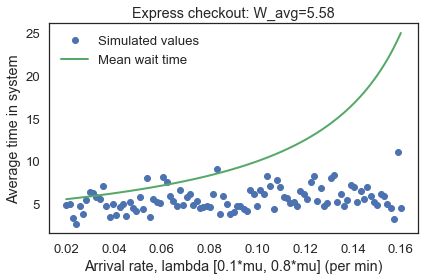

In [18]:

""" Generate Data: Express checkout scenario
"""
kwargs = {'lam':1/8, 'mu':1/5, 'express':1/4, 'duration': 10*60}
system = make_system(kwargs)


lam_array = param_sweep(0.1, 0.8, system.mu, 101)
sweep = sweep_lam_express(lam_array, 
                          system,
                          update_func_express, 
                          run_simulation_express);

""" Plot theoretical and simulated data: Express checkout scenario
"""
# Calculate theoretical mean wait times
W = 1 / (system.mu - lam_array)
W_avg = sweep.mean()
W_avg = round(W_avg, 2)


# Plot simulated scenario
plot(sweep, 'bo', label="Simulated values")
plot(lam_array, W, 'g-', label="Mean wait time")
decorate(xlabel='Arrival rate, lambda [0.1*mu, 0.8*mu] (per min)',
         ylabel='Average time in system',
         title='Express checkout: W_avg='+str(W_avg) )

### Results
Which checkout configuration should be adopted?

The express checkout should be adopted as it averages a lower checkout time compared to the other methods tested. From a theoretical point of view, having an express checkout is better and reduce the service time.


Adapted from: Case Study Queueing theory. 
Copyright 2017 Allen Downey
License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)
